In [1]:
import os
import pickle
from src.util import plotting_util as putil
import pandas as pd
import fnmatch
from src.util import eval_util as eutil
import seaborn as sns

REPO_DIR = os.path.join(os.getcwd(), "../")
os.chdir(REPO_DIR)

SITES = ["m5", "m8"]
MIG_TYPES = ["mS", "M", "S", "R"]
CUTOFF = 0.95

bins = {}
for x in range(7,15):
    bins[x]=0
for x in range(15,23):
    bins[x]=1
for x in range(23,31):
    bins[x]=2
bins

NOTE: Redirects are currently not supported in Windows or MacOs.


{7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 2,
 24: 2,
 25: 2,
 26: 2,
 27: 2,
 28: 2,
 29: 2,
 30: 2}

29


<Axes: xlabel='clusters', ylabel='Count'>

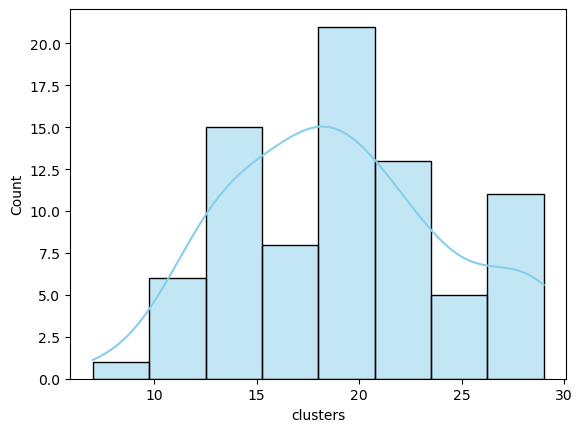

In [2]:
# Get number of clusters (tree vertices to label) per site/mig_type/seed combo
sims_dir = os.path.join(REPO_DIR, "data/machina_sims")
data = []
for site in SITES:
    for mig_type in MIG_TYPES:
        site_mig_type_dir = os.path.join(sims_dir, site, mig_type)
        seeds = fnmatch.filter(os.listdir(site_mig_type_dir), 'clustering_observed_seed*.txt')
        seeds = [s.replace(".txt", "").replace("clustering_observed_seed", "") for s in seeds]
        for seed in seeds:
            fn = os.path.join(site_mig_type_dir, f"clustering_observed_seed{seed}.txt")
            num_lines = sum(1 for _ in open(fn))
            data.append([seed, site, mig_type, num_lines])
            
cols = ["seed", "site", "mig_type", "clusters"]
cluster_num_df = pd.DataFrame(data, columns=cols)
cluster_num_df["seed"] = cluster_num_df["seed"].astype(int)
print(cluster_num_df['clusters'].max())
sns.histplot(cluster_num_df['clusters'], kde=True, color='skyblue')

In [3]:
cluster_num_df[cluster_num_df['clusters']>20]

,seed,site,mig_type,clusters
9,3,m5,mS,23
18,473,m5,M,23
42,8,m8,mS,27
44,7,m8,mS,21
46,5,m8,mS,21
47,0,m8,mS,29
49,3,m8,mS,28
50,241,m8,M,23
51,76,m8,M,23
52,243,m8,M,28


In [4]:
batch_sizes = ['16', '32', '64', '128', '512', '1024']

bs_to_num_nodes_to_ground_truth_slns = {}
for bs in batch_sizes:
    prediction_dir = os.path.join(REPO_DIR, 'test', 'prediction_outputs', f'predictions_bs_{bs}_gd_08282023')
    print(prediction_dir)
    bs_to_num_nodes_to_ground_truth_slns[bs] = {}
    grad_m5_f1_scores = []
    grad_m8_f1_scores = []
    for site in SITES:
        for mig_type in MIG_TYPES:
            true_site_mig_type_data_dir = os.path.join(sims_dir, site, mig_type)
            predicted_site_mig_type_data_dir = os.path.join(prediction_dir, site, mig_type)
            filenames = fnmatch.filter(os.listdir(predicted_site_mig_type_data_dir), 'T_tree*.predicted.tree')
            seeds = set([int(s[s.find("seed")+4:s.find(".predicted")]) for s in filenames])
            for seed in seeds:
                seed_filenames = [f for f in filenames if seed == f[f.find("seed")+4:f.find(".predicted")]]
                # TODO: should we evaluate "top" differently? i.e. top 3 per tree? or 
                print(site, mig_type, seed)
                tree_info = eutil.get_metient_min_loss_trees(predicted_site_mig_type_data_dir, seed, 5, loss_thres=50.0)
                print(tree_info)
                ground_truth_clones_found = False
                ground_truth_mig_graph_found = False
                for loss, clone_tree_num, met_tree_num in tree_info:
                    
                    metient_pickle_fn = os.path.join(predicted_site_mig_type_data_dir, f"tree{clone_tree_num}_seed{seed}.pickle")
    
                    recall, precision, F, has_resolved_polytomy = eutil.evaluate_seeding_clones(os.path.join(true_site_mig_type_data_dir, f"T_seed{seed}.tree"),
                                                                  os.path.join(true_site_mig_type_data_dir, f"T_seed{seed}.vertex.labeling"),
                                                                  metient_pickle_fn, met_tree_num)
    
                    
                    if F >= CUTOFF:
                        ground_truth_clones_found = True
    
                    recall_G2, precision_G2, F_G2 = eutil.evaluate_migration_multigraph(os.path.join(true_site_mig_type_data_dir, f"G_seed{seed}.tree"),
                                                                                        metient_pickle_fn, met_tree_num)
                    if F_G2 >= CUTOFF:
                        ground_truth_mig_graph_found = True   
                num_nodes = cluster_num_df[(cluster_num_df['seed']==int(seed))&(cluster_num_df['site']==site)&(cluster_num_df['mig_type']==mig_type)]['clusters'].item()
                rng = bins[num_nodes]
                if rng not in bs_to_num_nodes_to_ground_truth_slns[bs]:
                    bs_to_num_nodes_to_ground_truth_slns[bs][rng] = []
                bs_to_num_nodes_to_ground_truth_slns[bs][rng].append((ground_truth_clones_found, ground_truth_mig_graph_found, F, F_G2))
bs_to_num_nodes_to_ground_truth_slns

/Users/divyakoyyalagunta/Desktop/Cornell_Research/Morris_Lab/met_history_prediction/src/jupyter_notebooks/../test/prediction_outputs/predictions_bs_16_gd_08282023
m5 mS 0
[(96.391, '0', 0), (96.732, '0', 1), (106.166, '1', 0), (106.175, '1', 1), (108.147, '1', 2)]
m5 mS 2
[(87.112, '0', 0), (87.27, '1', 0), (96.924, '2', 0), (97.082, '3', 0), (97.101, '0', 1)]
m5 mS 3
[(102.93, '0', 0), (102.931, '3', 0), (102.94, '1', 0), (102.967, '2', 0), (124.293, '0', 1)]
m5 mS 4
[(91.324, '2', 0), (91.341, '1', 0), (100.904, '0', 0), (100.955, '2', 1), (100.959, '1', 1)]
m5 mS 5
[(75.711, '0', 0), (108.452, '0', 1)]
m5 mS 7
[(96.417, '1', 0), (96.779, '1', 1), (106.186, '0', 0), (107.213, '0', 1), (107.221, '0', 2)]
m5 mS 8
[(97.013, '7', 0), (97.014, '0', 0), (97.014, '9', 0), (97.022, '3', 0), (97.033, '4', 0)]
m5 mS 9
[(81.667, '0', 0), (91.341, '0', 1), (91.674, '0', 2), (91.702, '0', 3), (98.338, '0', 4)]
m5 mS 10
[(107.373, '1', 0), (107.385, '0', 0), (107.405, '1', 1), (113.52, '1', 2), (1

{'16': {1: [(True, False, 1.0, 0.8),
   (True, False, 1.0, 0.8),
   (False, False, 0.9090909090909091, 0.6153846153846154),
   (True, False, 1.0, 0.8571428571428571),
   (False, False, 0.8333333333333334, 0.47058823529411764),
   (False, False, 0.8888888888888888, 0.5714285714285714),
   (False, True, 0.4, 0.5333333333333333),
   (True, False, 1.0, 0.7142857142857143),
   (True, False, 0.42857142857142855, 0.47058823529411764),
   (True, False, 0.2, 0.7692307692307692),
   (False, False, 0.9090909090909091, 0.14285714285714285),
   (True, False, 1.0, 0.9230769230769229),
   (False, False, 0.8, 0.5),
   (False, False, 0.8888888888888888, 0.7777777777777779),
   (True, False, 1.0, 0.9473684210526315),
   (True, False, 1.0, 0.7142857142857143),
   (False, False, 0.8888888888888888, 0.375),
   (False, False, 0.75, 0.7692307692307694),
   (True, True, 0.3076923076923077, 0.625),
   (False, False, 0.5, 0.823529411764706),
   (True, False, 0.8, 0.4444444444444444),
   (False, False, 0.6666666

In [5]:
# Load machina results
mach_node_size_to_ground_truth_slns = {}
machina_m5_df, machina_m8_df = eutil.load_machina_results(os.path.join(REPO_DIR, 'test'))
col_mapping = {"FscoreT": "migrating clones F1 score", "FscoreMultiG": "migration graph F1 score", "pattern": "seeding pattern", "seed":"seed"}
machina_m5_df = machina_m5_df.rename(columns=col_mapping)
machina_m8_df = machina_m8_df.rename(columns=col_mapping)
for site, df in zip(['m5', 'm8'],[machina_m5_df, machina_m8_df]):
    for i, row in df.iterrows():
        pattern = row['seeding pattern'].replace("p", "")
        num_nodes = cluster_num_df[(cluster_num_df['seed']==int(row['seed']))&(cluster_num_df['site']==site)&(cluster_num_df['mig_type']==pattern)]['clusters'].item()
        rng = bins[num_nodes]
        if rng not in mach_node_size_to_ground_truth_slns:
            mach_node_size_to_ground_truth_slns[rng] = []
        ground_truth_clones_found = False
        ground_truth_mig_graph_found = False
        if float(row['migrating clones F1 score']) >= CUTOFF:
            ground_truth_clones_found = True
        if float(row['migration graph F1 score']) >= CUTOFF:
            ground_truth_mig_graph_found = True
        
        mach_node_size_to_ground_truth_slns[rng].append((ground_truth_clones_found, ground_truth_mig_graph_found, row['migrating clones F1 score'], row['migration graph F1 score']))
mach_node_size_to_ground_truth_slns

{1: [(False, False, 0.666666666667, 0.5),
  (False, False, 0.666666666667, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (False, False, 0.75, 0.5),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.727272727273),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.666666666667),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.666666666667),
  (True, False, 1.0, 0.666666666667),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.5),
  (True, False, 1.0, 0.833333333333),
  (True, False, 1.0, 0.833333333333),
  (True,

In [6]:
data = []
for bs in bs_to_num_nodes_to_ground_truth_slns:
    for num_nodes in bs_to_num_nodes_to_ground_truth_slns[bs]:
        gt_list = bs_to_num_nodes_to_ground_truth_slns[bs][num_nodes]
        percent_true_clones = sum(1 for item in gt_list if item[0]) / len(gt_list) * 100
        percent_true_mig_graph = sum(1 for item in gt_list if item[1]) / len(gt_list) * 100
        avg_clones_f1 = sum(item[2] for item in gt_list) / len(gt_list) * 100
        avg_mig_graph_f1 = sum(item[3] for item in gt_list) / len(gt_list) * 100
        data.append([f"Metient-{bs}", num_nodes, avg_clones_f1, avg_mig_graph_f1, percent_true_clones, percent_true_mig_graph])

for num_nodes in mach_node_size_to_ground_truth_slns:
    gt_list = mach_node_size_to_ground_truth_slns[num_nodes]
    percent_true_clones = sum(1 for item in gt_list if item[0]) / len(gt_list) * 100
    percent_true_mig_graph = sum(1 for item in gt_list if item[1]) / len(gt_list) * 100
    avg_clones_f1 = sum(item[2] for item in gt_list) / len(gt_list) * 100
    avg_mig_graph_f1 = sum(item[3] for item in gt_list) / len(gt_list) * 100
    data.append(["MACHINA", num_nodes, avg_clones_f1, avg_mig_graph_f1, percent_true_clones, percent_true_mig_graph])
results = pd.DataFrame(data, columns=["Method", "Number of Tree Nodes", "Migrating clones F1-score", "Migration graph F1-score", "% time that migrating clone ground truth found", "% time that migration graph ground truth found"])
results


,Method,Number of Tree Nodes,Migrating clones F1-score,Migration graph F1-score,% time that migrating clone ground truth found,% time that migration graph ground truth found
0,Metient-16,1,78.169,63.256,53.659,7.317
1,Metient-16,0,72.440,68.832,77.778,16.667
2,Metient-16,2,77.156,57.871,28.571,4.762
3,Metient-32,1,78.680,61.816,58.537,4.878
4,Metient-32,0,75.024,76.886,77.778,22.222
5,Metient-32,2,76.499,57.772,23.810,9.524
6,Metient-64,1,84.315,63.904,63.415,7.317
7,Metient-64,0,74.098,73.043,77.778,22.222
8,Metient-64,2,79.030,65.322,23.810,9.524
9,Metient-128,1,90.534,68.102,68.293,7.317


[(0.96516917, 0.70776351, 0.5606593), (0.95381595, 0.46373781, 0.31769923), (0.8833417, 0.19830556, 0.26014181), (0.67824099, 0.09192342, 0.3504148), (0.43860848, 0.12177004, 0.34119475), (0.20973515, 0.09747934, 0.24238489), (0.18, 0.54, 0.34)]


/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


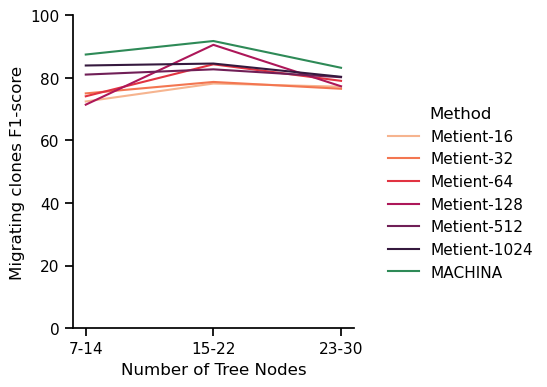

/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


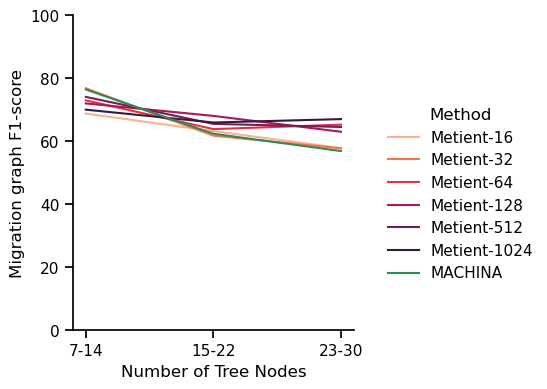

/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


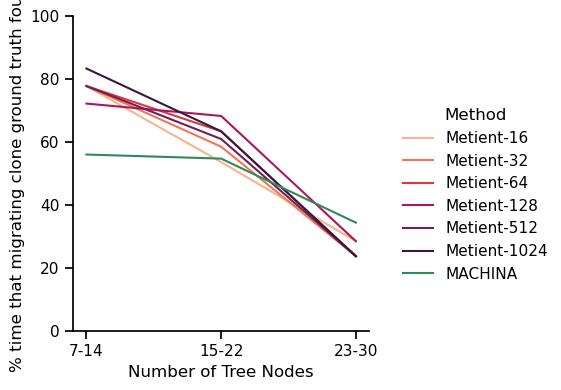

/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/Users/divyakoyyalagunta/mambaforge/envs/met/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


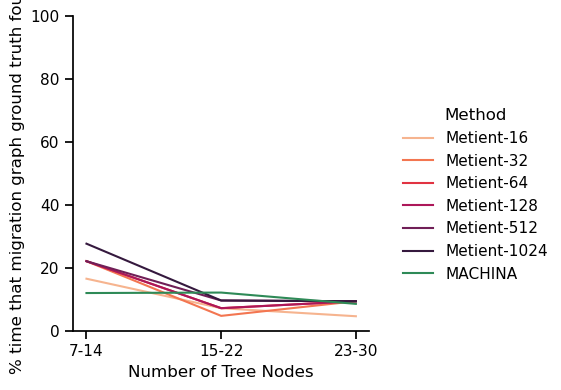

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.color_palette("rocket")
colors.reverse()
colors = colors[:6]
colors.append((0.18, 0.54, 0.34))
print(colors)
sns.set_palette(sns.color_palette(colors))
ys = ["Migrating clones F1-score", "Migration graph F1-score", "% time that migrating clone ground truth found", "% time that migration graph ground truth found"]

category_mapping = {'0-9': 1, '10-19': 2, '20-30': 3}

for y in ys:
    with sns.plotting_context("notebook", font_scale=1):
        g = sns.relplot(
            data=results, x="Number of Tree Nodes", y=y,
            height=4, aspect=1.0, dashes=False,
            hue="Method", style="Method", kind="line", errorbar='sd', legend=True,
        )
        labels = ['7-14', '15-22', '23-30']
        plt.xticks(ticks=[0.0,1.0,2.0],labels=['7-14', '15-22', '23-30'])
        (g.set_axis_labels("Number of Tree Nodes", y)
          .set_titles("boop")
          .tight_layout(w_pad=0))
        plt.ylim(0, 100)
        
       # plt.legend(title='', loc='upper left', labels=['Metient', 'Metient CI (1 SD)', "MACHINA", "MACHINA CI (1 SD)"], prop={'size': 10}, frameon=False)
        plt.show()
    
        fig = g.fig
        fig.savefig(f"{y}.png", dpi=600) 
